# Toy 4: Training KAN with Saltelli Sample Data

Gives almost the same result, which is coherency!

In [5]:
import torch
from SALib.sample import sobol
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

ground_truth = lambda x: np.exp(-2 * x[:, [0]]) + x[:, [1]]
nx = 2
problem = {
    'num_vars': nx,
    'names': [f'x{i+1}' for i in range(nx)],
    'bounds': [[-1, 1]] * nx
}
x_descaled_saltelli = sobol.sample(problem, 2048)
y_descaled_satelli = ground_truth(x_descaled_saltelli).reshape(-1, 1)

X = x_descaled_saltelli
X_train, X_test, y_train, y_test = train_test_split(X, y_descaled_satelli, test_size=0.1, random_state=42)

y_mean = y_train.mean()
y_std = y_train.std()

def y_scaler(y_data):
    return (y_data - y_mean) / y_std

def y_descaler(y_data):
    return (y_data * y_std) + y_mean

y_train_norm = y_scaler(y_train)
y_test_norm = y_scaler(y_test)

| train_loss: 1.86e-02 | test_loss: 1.88e-02 | reg: 2.30e+00 | : 100%|█| 20/20 [00:04<00:00,  4.03it
| train_loss: 2.52e-05 | test_loss: 2.46e-05 | reg: 4.65e+00 | : 100%|█| 50/50 [00:04<00:00, 11.18it


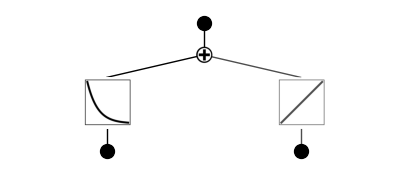

In [6]:
from kan.custom import MultKAN
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = {
    'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
    'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
    'train_label': torch.tensor(y_train_norm, dtype=torch.float32).to(device),
    'test_label': torch.tensor(y_test_norm, dtype=torch.float32).to(device)
}

grids_to_sym = [10]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

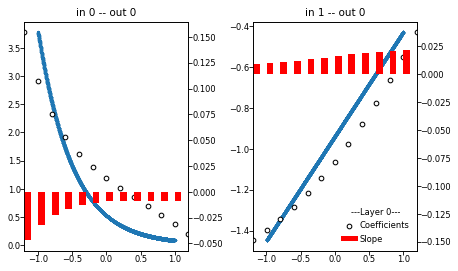

[<Figure size 450x262.5 with 4 Axes>]

In [7]:
from kan.custom_processing import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

r2 is 1.0000004768371582
fixing (0,0,0) with exp, r2=1.0, c=2
r2 is 1.0000004768371582
fixing (0,1,0) with x, r2=1.0, c=1


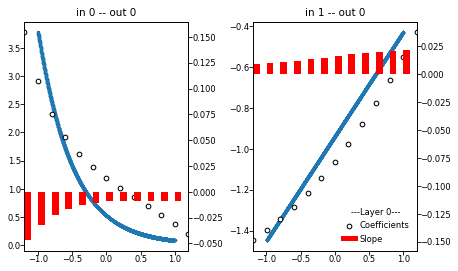

[<Figure size 450x262.5 with 4 Axes>]

In [8]:
model.auto_symbolic()
plot_activation_and_spline_coefficients(model, x=dataset)

| train_loss: 2.80e-07 | test_loss: 2.73e-07 | reg: 0.00e+00 | : 100%|█| 100/100 [00:04<00:00, 23.11


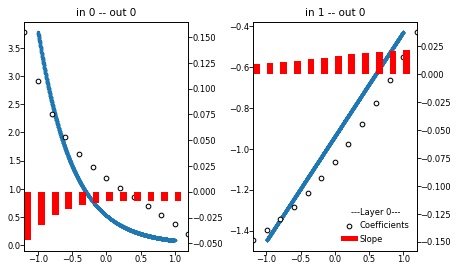

[<Figure size 450x262.5 with 4 Axes>]

In [9]:
from kan.utils import ex_round
model.fit(dataset)
ex_round(model.symbolic_formula()[0][0], 4)
plot_activation_and_spline_coefficients(model, x=dataset)

Text(0, 0.5, 'Attribution score')

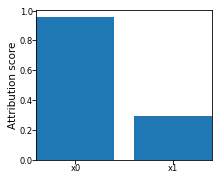

In [10]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

[tensor(2773), tensor(2764), tensor(2758), tensor(2764)]


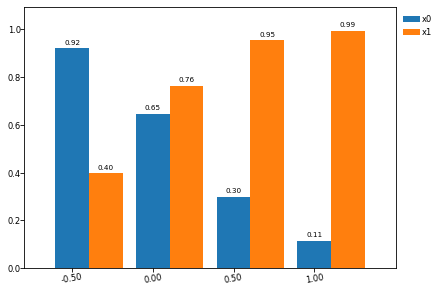

In [11]:
mask_idx = 0
mask_interval = [-1, -0.5, 0., 0.5, 1]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()